In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [3]:
import StateUtilities as SU

In [4]:
import visualization_helper_v2 as vh

In [5]:
fig_width = 15

In [10]:
dirnames = ["../checkpoints/s111/20210503-1229/",
            "../checkpoints/s112/20210503-1207/",
            "../checkpoints/s121/20210503-2052/"]

In [11]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


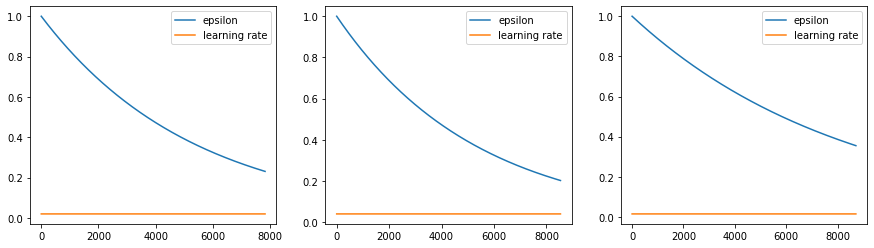

In [12]:
_, axes = plt.subplots(nrows=1, ncols=len(alldfs), figsize=(fig_width,4), sharex=False)
for idx, dfs in enumerate(alldfs):
    vh.plot_lr_epsilon(dfs, axes[idx])

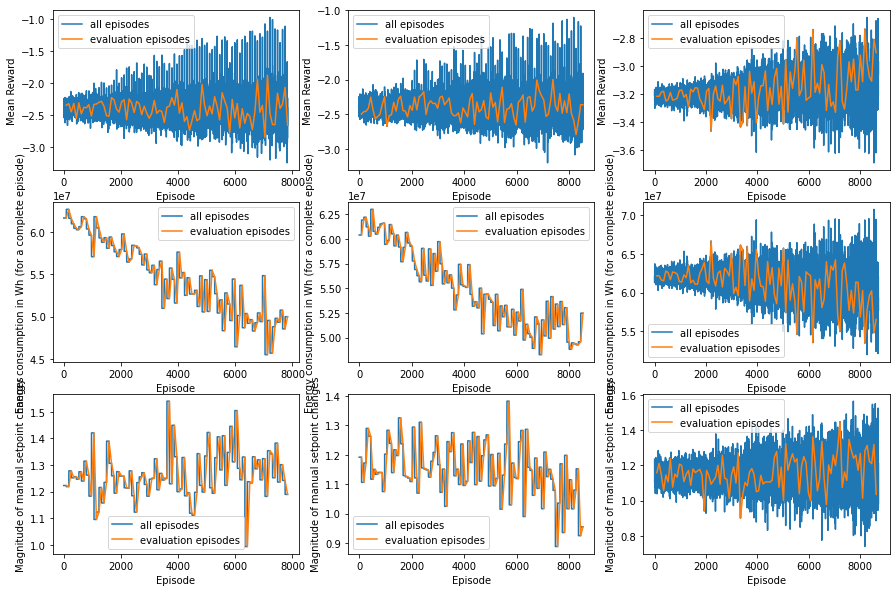

In [13]:
_, axes = plt.subplots(nrows=3, ncols=len(alldfs), figsize=(fig_width,10), sharex=False)
for idx, dfs in enumerate(alldfs):
    vh.plot_eels_reward(dfs, axes[:, idx])

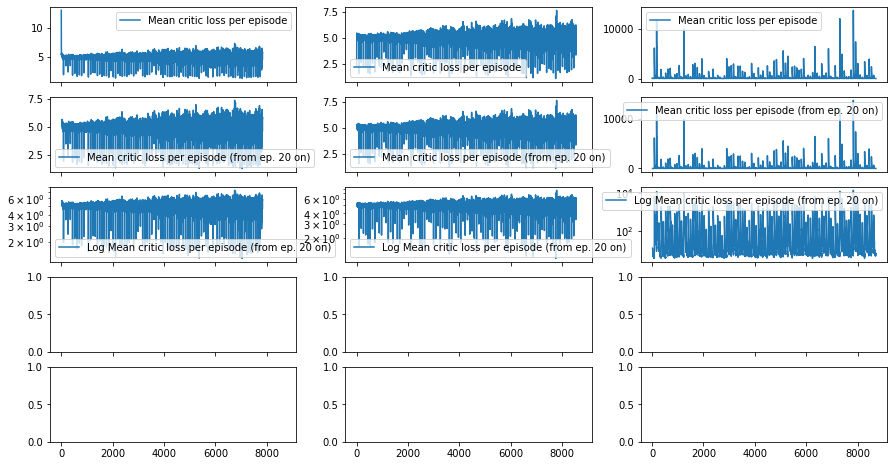

In [14]:
_, axes = plt.subplots(nrows=5, ncols=len(alldfs), figsize=(fig_width,8), sharex=True)
for idx, dfs in enumerate(alldfs):
    vh.plot_eels_agent_details(dfs, axes[:, idx])

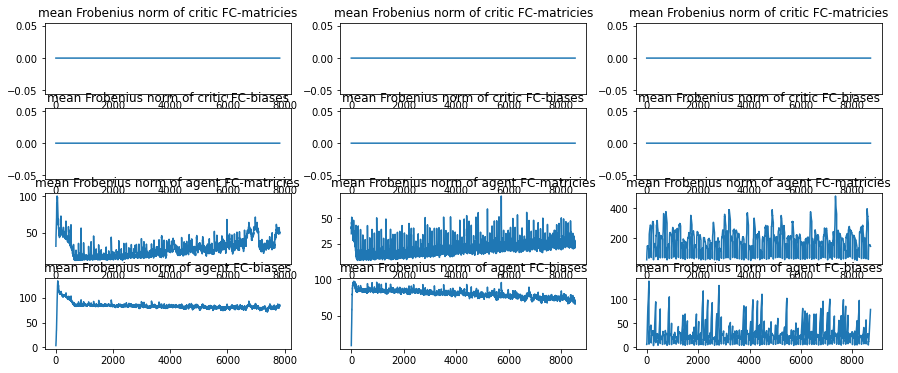

In [15]:
_, axes = plt.subplots(nrows=4, ncols=len(alldfs), figsize=(fig_width,6))
for idx, dfs in enumerate(alldfs):
    vh.plot_eels_agent_details_frobnorm(dfs, axes[:, idx])

In [16]:
last_available_eval_episodes = []
for idx, dfs in enumerate(alldfs):
    last_eval_episode = dfs['sees'].loc[:, "episode"].unique()[-1]
    last_available_eval_episodes.append(last_eval_episode)
    print(f"Last available evaluation episode for dfs{idx}: {last_eval_episode:6}")

Last available evaluation episode for dfs0:   7831
Last available evaluation episode for dfs1:   8535
Last available evaluation episode for dfs2:   8623


<h3>Details: Temperatur Setpoints for one week</h3>

In [17]:
#selected_episodes = [13120 - 1, 14480 - 1, 14480 - 1]
#selected_weeks    = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1)]

In [18]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = []
for idx, dfs in enumerate(alldfs):
    subdfs1 = vh.select_week_and_episode(dfs, selected_episodes[idx], selected_weeks[idx])
    subdfs.append( subdfs1 )

In [ ]:
print("First complete week of evaluation episode")
for idx, dfs in enumerate(subdfs):
    econs = dfs['eels'].iloc[0]['sum_energy_Wh']/1000
    nstpc = dfs['eels'].iloc[0]['sum_manual_stp_ch_n'] if 'sum_manual_stp_ch_n' in dfs['eels'].columns else "?"
    print(f"For episode {selected_episodes[idx]:5}: Energy consumption: {econs:10.2f} kWh; Numer of setpoint changes: {nstpc:8}")
print()
print("Mean values for episode ...")
for idx, dfs in enumerate(subdfs):
    mrwd  = dfs['eels'].iloc[0]['mean_reward']
    nstpc = dfs['eels'].iloc[0]['mean_manual_stp_ch_n']
    econs = dfs['eels'].iloc[0]['mean_energy_Wh']
    print(f"... {selected_episodes[idx]:5}: Reward: {mrwd:8.5f} kWh; Setpoint change magnit.: {nstpc:8.5f}; Energy cons.: {econs:8.5f}")

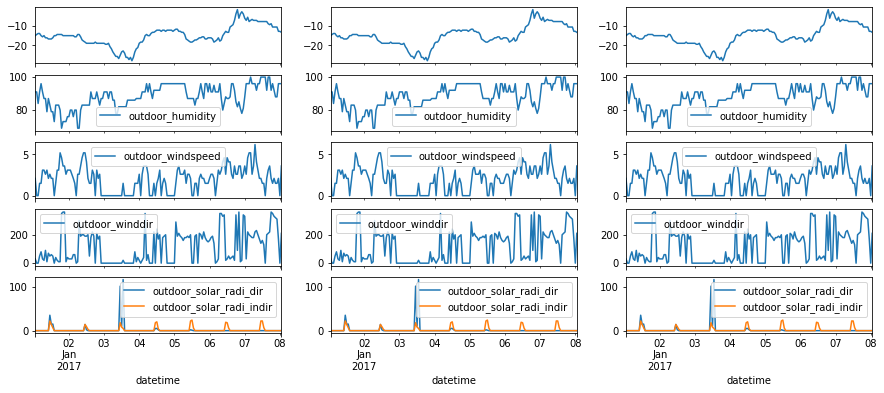

In [22]:
_, axes = plt.subplots(nrows=5, ncols=len(alldfs), figsize=(fig_width,6), sharex=True)
for idx, dfs in enumerate(alldfs):
    vh.plot_sees(subdfs[idx], axes[:, idx])

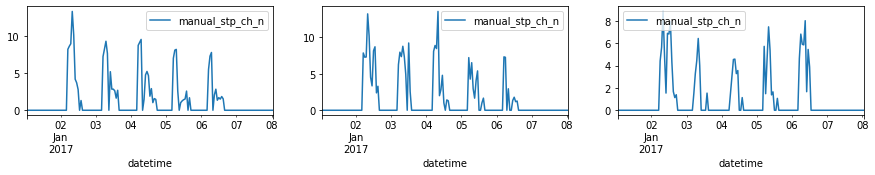

In [23]:
_, axes = plt.subplots(nrows=1, ncols=len(alldfs), figsize=(fig_width,2))
for idx, dfs in enumerate(alldfs):
    vh.plot_sees_only_mstpc(subdfs[idx], axes[idx])

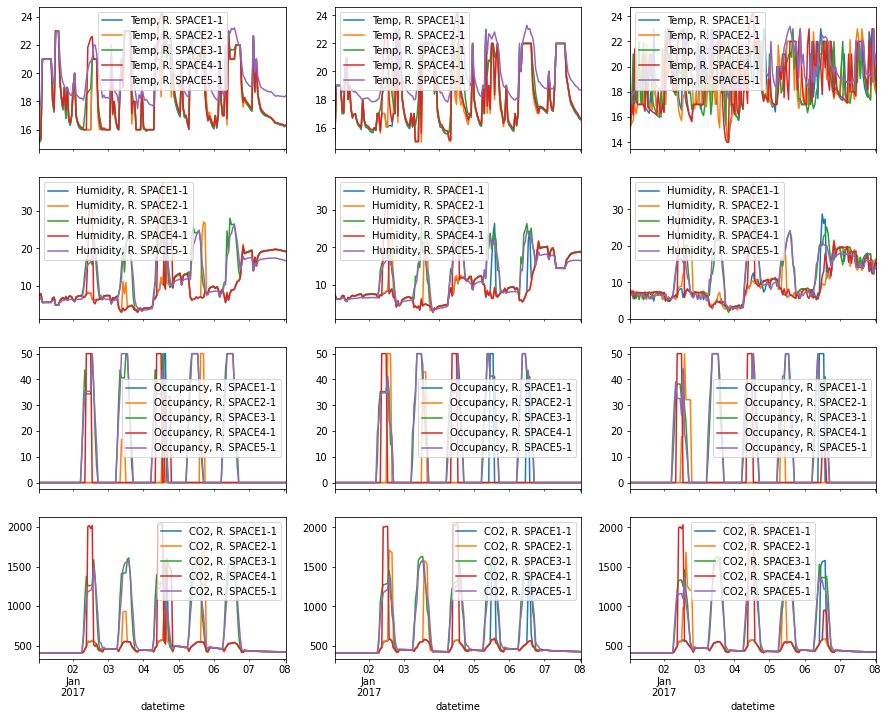

In [24]:
_, axes = plt.subplots(nrows=4, ncols=len(alldfs), figsize=(fig_width,12), sharex=True)
for idx, dfs in enumerate(alldfs):
    vh.plot_seeser_all_rooms(subdfs[idx], axes[:, idx])
# for individual rooms use plot_seeser(subdfs, room_id, ax)

In [25]:
subdfs_rooms  = []
subdfs_agents = []

for idx, sdfs in enumerate(subdfs):
    sdfs_rooms  = sdfs["seeser"].loc[:, "room"].unique()
    sdfs_agents = sdfs["seesea"].loc[:, "agent_nr"].unique()
    subdfs_rooms.append(sdfs_rooms)
    subdfs_agents.append(sdfs_agents)
    print(f"Available Rooms     in subdfs{idx}: {sdfs_rooms}")
    print(f"Available Agent IDs in subdfs{idx}: {sdfs_agents}", "\n")

Available Rooms     in subdfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in subdfs0: [0] 

Available Rooms     in subdfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in subdfs1: [0] 

Available Rooms     in subdfs2: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in subdfs2: [0 1 2 3 4] 



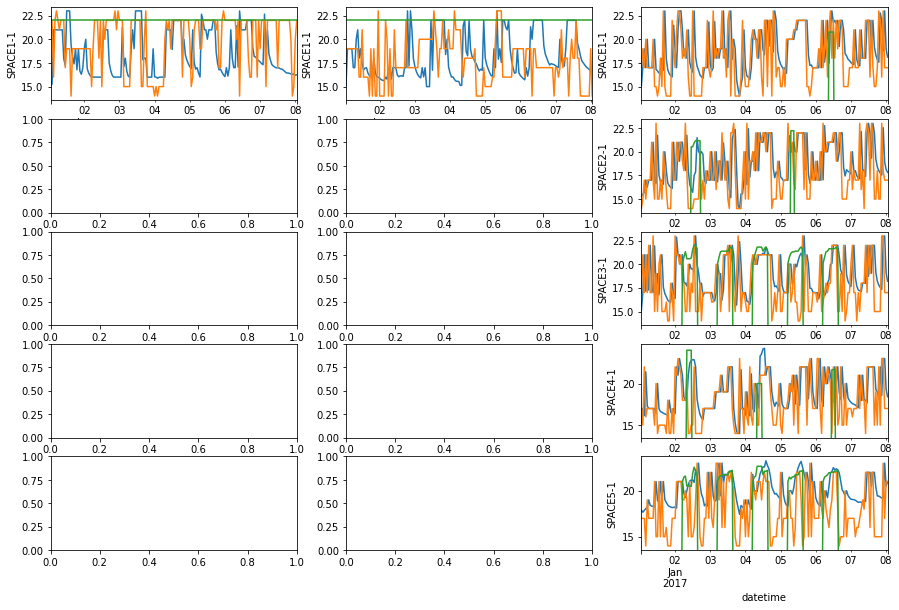

In [26]:
max_n_agents = max(2, max([len(sdfs_agents) for sdfs_agents in subdfs_agents]))
_, axes = plt.subplots(nrows=max_n_agents, ncols=len(alldfs), figsize=(fig_width,2*max_n_agents))
for idx, sdfs in enumerate(subdfs):
    for idx2, room, agentid in zip(range(len(subdfs_rooms[idx])), subdfs_rooms[idx], subdfs_agents[idx]):
        vh.plot_room_temp_agent_setpoint(sdfs, room, agentid, axes[idx2, idx])

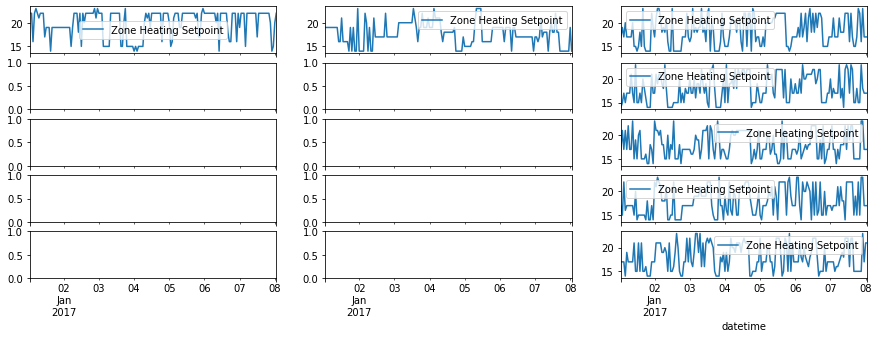

In [27]:
nrows = max_n_agents * max([sdfs['seesea'].iloc[0]["agent_actions"].count(":") for sdfs in subdfs])
_, axes = plt.subplots(nrows=nrows, ncols=len(alldfs), figsize=(fig_width,nrows), sharex=True)
for a in axes.flatten():
    a.ticklabel_format(useOffset=False, style='plain')
for idx, sdfs in enumerate(subdfs):
    vh.plot_seesea(sdfs, axes[:, idx])

<h3>Details for a day</h3>

In [28]:
selected_periods     = [datetime.datetime(2017, 1, 3), datetime.datetime(2017, 1, 3), datetime.datetime(2017, 1, 3)]
selected_periods_end = [datetime.datetime(2017, 1, 4), datetime.datetime(2017, 1, 4), datetime.datetime(2017, 1, 4)]

subdfs = []
for idx, dfs in enumerate(alldfs):
    subdfs1 = vh.select_week_and_episode(dfs, selected_episodes[idx],
                                         selected_periods[idx], selected_periods_end[idx])
    subdfs.append(subdfs1)

/proj/ciptmp/me14miju/pyenvs/masterarbeit37/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


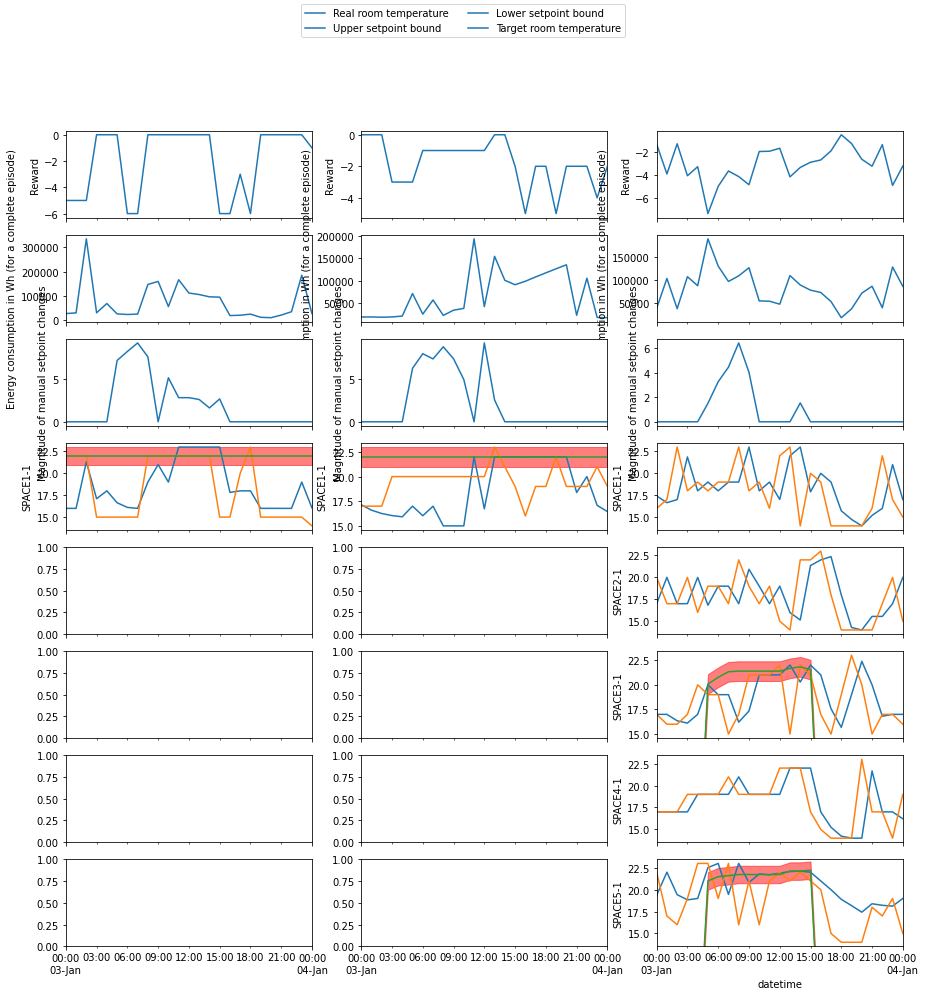

In [29]:
max_n_agents = max(2, max([len(sdfs_agents) for sdfs_agents in subdfs_agents]))
p, axes = plt.subplots(nrows=max_n_agents+3, ncols=len(alldfs), figsize=(fig_width,3*max_n_agents), sharex=True)
legend_handles = []
legend_labels  = []

# plot rewards
for idx, dfs in enumerate(alldfs):
    vh.plot_sees_reward(subdfs[idx], axes[:, idx])

# plot for every room
for idx, sdfs in enumerate(subdfs):
    for idx2, room, agentid in zip(range(len(subdfs_rooms[idx])), subdfs_rooms[idx], subdfs_agents[idx]):
        idx2offset = idx2+3
        l4, l5, l6, l7 = vh.plot_room_temp_agent_setpoint(sdfs, room, agentid, axes[idx2offset, idx], True)
        handles, labels = axes[idx2offset, idx].get_legend_handles_labels()
        legend_handles.extend(handles)
        legend_labels.extend(labels)

p.legend(handles, labels, loc='lower center', ncol=2)
#p.subplots_adjust(right=0.7)
p.show()

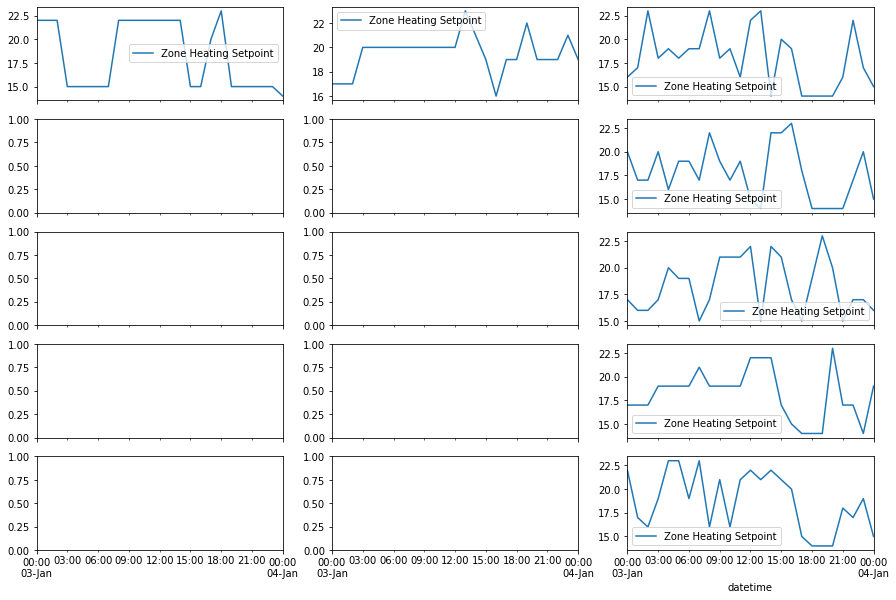

In [30]:
nrows = max_n_agents * max([sdfs['seesea'].iloc[0]["agent_actions"].count(":") for sdfs in subdfs])
_, axes = plt.subplots(nrows=nrows, ncols=len(alldfs), figsize=(fig_width,2*nrows), sharex=True)
for a in axes.flatten():
    a.ticklabel_format(useOffset=False, style='plain')
for idx, sdfs in enumerate(subdfs):
    vh.plot_seesea(sdfs, axes[:, idx])